<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_041_balance_weights_%26_resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import sklearn
print(sklearn.__version__)

1.3.2


### Train Model with Balanced Class Weights

In [17]:
# Define the experiment name
experiment_name = 'class_weight_balanced'

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import logging
from loan_data_utils import load_and_preprocess_data, evaluate_model, compile_metrics
import json

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# load and preprocess
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the models to evaluate with class_weight='balanced'
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),  # Does not support class_weight
    'LGBM': LGBMClassifier(class_weight='balanced', random_state=42)
}

# List to store metrics for each model
metrics_list = []

# Evaluate each model and capture metrics
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    metrics = evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name)
    metrics_list.append(metrics)

# Compile metrics into a DataFrame and save to CSV with experiment name
metrics_df = compile_metrics(metrics_list, experiment_name=experiment_name)

# Save the new metrics to a CSV file
metrics_df.to_csv(f'{experiment_name}_metrics.csv', index=False)
logger.info(f"{experiment_name} metrics saved to {experiment_name}_metrics.csv")

# Import the previous CSV of metrics
baseline_metrics_df = pd.read_csv('baseline_metrics.csv')

# Concatenate the previous metrics with the new metrics
combined_metrics_df = pd.concat([baseline_metrics_df, metrics_df], ignore_index=True)

# Save the combined metrics DataFrame to a new CSV file
combined_metrics_df.to_csv('combined_model_metrics.csv', index=False)
logger.info("Combined metrics saved to combined_model_metrics.csv")

# Optionally, save the best performing model
best_model_name = combined_metrics_df.loc[combined_metrics_df['F1_Macro'].idxmax(), 'Model']
best_model = models[best_model_name]

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
        ('classifier', best_model)
])

pipeline.fit(X_train, y_train)
joblib.dump(pipeline, f'best_model_{best_model_name}.pkl')
logger.info(f"Best model saved as best_model_{best_model_name}.pkl")

# Display the metrics DataFrame
metrics_df


[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [bin

,Model,Experiment,Recall_0,Precision_0,F1_0,Recall_1,Precision_1,F1_1,F1_Macro,Accuracy
0,Logistic Regression,class_weight_balanced,0.691419,0.868782,0.770019,0.632253,0.367821,0.465078,0.617548,0.678333
1,Random Forest,class_weight_balanced,0.947143,0.835094,0.887597,0.341372,0.647143,0.446966,0.667281,0.813167
2,HistGradientBoosting,class_weight_balanced,0.942863,0.840198,0.888575,0.368500,0.646825,0.469515,0.679045,0.815833
3,LGBM,class_weight_balanced,0.799700,0.880122,0.837986,0.616428,0.466363,0.530996,0.684491,0.759167


### Analyze Results

In [18]:
combined_metrics_df

,Model,Experiment,Recall_0,Precision_0,F1_0,Recall_1,Precision_1,F1_1,F1_Macro,Accuracy
0,Logistic Regression,baseline,0.969399,0.818724,0.887713,0.244160,0.693790,0.361204,0.624459,0.809000
1,Random Forest,baseline,0.939225,0.839679,0.886667,0.368500,0.632600,0.465714,0.676190,0.813000
2,HistGradientBoosting,baseline,0.942863,0.840198,0.888575,0.368500,0.646825,0.469515,0.679045,0.815833
3,LGBM,baseline,0.947143,0.840486,0.890633,0.366993,0.663488,0.472586,0.681609,0.818833
4,Logistic Regression,class_weight_balanced,0.691419,0.868782,0.770019,0.632253,0.367821,0.465078,0.617548,0.678333
5,Random Forest,class_weight_balanced,0.947143,0.835094,0.887597,0.341372,0.647143,0.446966,0.667281,0.813167
6,HistGradientBoosting,class_weight_balanced,0.942863,0.840198,0.888575,0.368500,0.646825,0.469515,0.679045,0.815833
7,LGBM,class_weight_balanced,0.799700,0.880122,0.837986,0.616428,0.466363,0.530996,0.684491,0.759167


In [19]:
combined_metrics_df[['Model', 'Experiment']] = combined_metrics_df[['Model', 'Experiment']].astype('category')
combined_metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Model        8 non-null      category
 1   Experiment   8 non-null      category
 2   Recall_0     8 non-null      float64 
 3   Precision_0  8 non-null      float64 
 4   F1_0         8 non-null      float64 
 5   Recall_1     8 non-null      float64 
 6   Precision_1  8 non-null      float64 
 7   F1_1         8 non-null      float64 
 8   F1_Macro     8 non-null      float64 
 9   Accuracy     8 non-null      float64 
dtypes: category(2), float64(8)
memory usage: 984.0 bytes


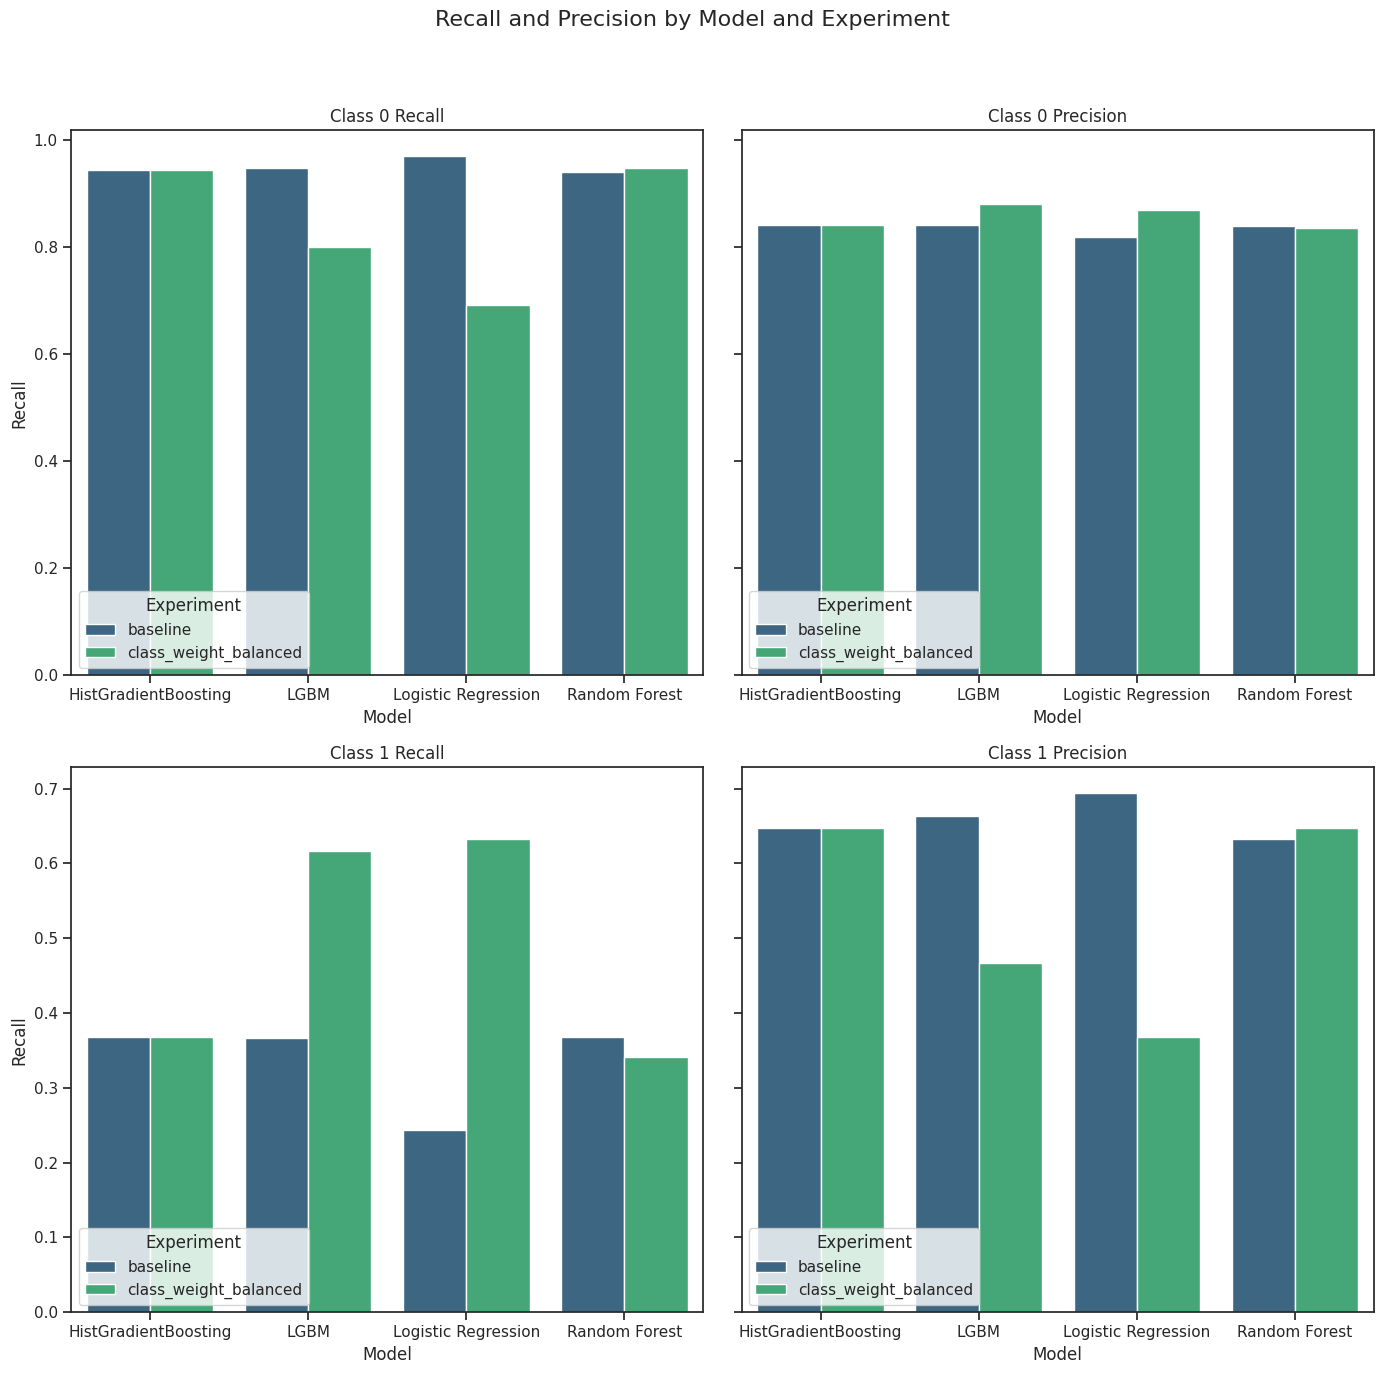

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_recall_precision(metrics_df):
    # Convert Model and Experiment columns to categorical data
    metrics_df[['Model', 'Experiment']] = metrics_df[['Model', 'Experiment']].astype('category')

    # Set up the seaborn palette
    palette = 'viridis'
    sns.set_context('notebook')
    sns.set_style('ticks')

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharey='row')
    fig.suptitle('Recall and Precision by Model and Experiment', fontsize=16)

    # Class 0 Recall
    sns.barplot(x='Model', y='Recall_0', hue='Experiment', data=metrics_df, ax=axes[0, 0], palette=palette)
    axes[0, 0].set_title('Class 0 Recall')
    axes[0, 0].set_ylabel('Recall')
    axes[0, 0].set_xlabel('Model')
    axes[0, 0].legend(title='Experiment', loc='lower left')

    # Class 0 Precision
    sns.barplot(x='Model', y='Precision_0', hue='Experiment', data=metrics_df, ax=axes[0, 1], palette=palette)
    axes[0, 1].set_title('Class 0 Precision')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_xlabel('Model')
    axes[0, 1].legend(title='Experiment', loc='lower left')

    # Class 1 Recall
    sns.barplot(x='Model', y='Recall_1', hue='Experiment', data=metrics_df, ax=axes[1, 0], palette=palette)
    axes[1, 0].set_title('Class 1 Recall')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_xlabel('Model')
    axes[1, 0].legend(title='Experiment', loc='lower left')

    # Class 1 Precision
    sns.barplot(x='Model', y='Precision_1', hue='Experiment', data=metrics_df, ax=axes[1, 1], palette=palette)
    axes[1, 1].set_title('Class 1 Precision')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_xlabel('Model')
    axes[1, 1].legend(title='Experiment', loc='lower left')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_recall_precision(combined_metrics_df)


### Performance Analysis

1. **Baseline Models**:
   - The baseline models generally have high recall and precision for class 0 (non-default), indicating that they are good at identifying non-defaults.
   - The recall for class 1 (default) is significantly lower, suggesting that the models are not as effective at identifying defaults.
   - Among the baseline models, LGBM has the highest F1 Macro score (0.682) and accuracy (0.819), making it the best performing model in this set.

2. **Class Weight Balanced Models**:
   - Adding class weights has improved the recall for class 1 in some cases, particularly for Logistic Regression (from 0.244 to 0.632) and LGBM (from 0.367 to 0.616).
   - However, the precision for class 1 is generally lower, especially for Logistic Regression and LGBM, indicating more false positives.
   - The F1 Macro scores for the class weight balanced models are slightly lower than their baseline counterparts, except for LGBM, which improved from 0.681 to 0.684.
   - The accuracy of the models remains relatively unchanged, indicating that class weight balancing does not drastically affect the overall accuracy.

### Conclusion

- **LGBM**:
  - The LGBM model performs well in both the baseline and class weight balanced scenarios. In the class weight balanced setup, it achieves a higher recall for class 1 (0.616) compared to the baseline (0.367), with a slight improvement in F1 Macro (0.684).
  
- **HistGradientBoosting**:
  - This model performs similarly in both scenarios with an F1 Macro of 0.679 and accuracy of 0.816, indicating stable performance regardless of class weight adjustments.
  
- **Logistic Regression**:
  - The class weight balanced Logistic Regression model has a much higher recall for class 1 (0.632), but its precision is lower, resulting in a lower F1 Macro score compared to the baseline.
  
- **Random Forest**:
  - The Random Forest model shows a slight decline in performance with class weight balancing, with a decrease in F1 Macro from 0.676 to 0.667.

### Recommendations

- **Focus on LGBM**: Given its consistent performance and improved recall for class 1 in the class weight balanced scenario, further tuning and optimization of the LGBM model might yield the best results.
- **Explore Threshold Tuning**: Adjusting decision thresholds for better precision-recall balance could further enhance model performance, particularly for Logistic Regression and Random Forest models.
- **Consider Resampling Techniques**: Techniques like SMOTE, ADASYN, or undersampling could be explored to address class imbalance more effectively.

Would you like to proceed with any specific model or optimization strategy based on this analysis?

### Resampling Methods

Balancing class weights and using resampling methods are both techniques used to address class imbalance in datasets. However, they serve different purposes and are typically used independently. Here's why they are not combined in the provided code:

### Balancing Class Weights

1. **Purpose**: Balancing class weights adjusts the cost function during model training to give more importance to the minority class. This helps the model pay more attention to the underrepresented class without altering the dataset.
2. **Implementation**: Class weights are set as parameters in the model, such as `class_weight='balanced'`.
3. **Pros**: It is simple to implement and does not change the data distribution. It works well for some models like Logistic Regression and Random Forest.
4. **Cons**: Not all models support class weights (e.g., some boosting algorithms). The impact might be limited if the class imbalance is severe.

### Resampling Methods

1. **Purpose**: Resampling methods directly alter the training data to balance the classes. This can be done by oversampling the minority class (e.g., SMOTE, ADASYN) or undersampling the majority class (e.g., RandomUnderSampler).
2. **Implementation**: Resampling methods are applied to the training data before fitting the model.
3. **Pros**: Effective at creating a balanced dataset, which can improve model performance significantly, especially for severe class imbalances.
4. **Cons**: Oversampling can lead to overfitting, as it duplicates or synthetically generates minority class samples. Undersampling can result in loss of important data from the majority class.

### Combining Class Weights and Resampling

- **Compatibility**: While it's theoretically possible to combine class weights and resampling, it is generally not necessary. Each method independently addresses class imbalance, and combining them might not provide additional benefits and could complicate the training process.
- **Risk of Overfitting**: Combining oversampling with class weights might overly emphasize the minority class, leading to overfitting.
- **Best Practice**: Typically, you would choose one method based on the model and the specific imbalance issue. For models that don't support class weights (e.g., certain boosting algorithms), resampling methods are preferred.

### When to Use Each Method

- **Class Weights**: Best for models that natively support it and for mild to moderate class imbalance.
- **Resampling**: Preferred for severe class imbalance or when using models that do not support class weights.

In summary, balancing class weights and resampling methods are powerful techniques for handling class imbalance, but they are typically used separately. The choice between them depends on the specific model and the nature of the class imbalance.

In [53]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Define the experiment name
experiment_name = 'resampling'

# Define the models to evaluate
base_models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'LGBM': LGBMClassifier(random_state=42)
}

# Define the resampling methods
resampling_methods = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42)
}

# List to store metrics for each model
metrics_list = []

# Evaluate each model with each resampling method
for resampling_name, resampler in resampling_methods.items():
    for model_name, model in base_models.items():
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampler),
            ('classifier', model)
        ])

        metrics = evaluate_model(pipeline, X_train, X_test, y_train, y_test, f'{model_name} ({resampling_name})', experiment_name)
        metrics_list.append(metrics)

# Compile metrics into a DataFrame and save to CSV with experiment name
metrics_df = compile_metrics(metrics_list, experiment_name=experiment_name)

# Display the metrics DataFrame
print(metrics_df)

# Save the new metrics to a CSV file
metrics_df.to_csv(f'{experiment_name}_metrics.csv', index=False)
logger.info(f"{experiment_name} metrics saved to {experiment_name}_metrics.csv")

# Import the previous CSV of metrics
previous_metrics_df = pd.read_csv('combined_model_metrics.csv')

# Concatenate the previous metrics with the new metrics
combined_metrics_df = pd.concat([previous_metrics_df, metrics_df], ignore_index=True)

# Save the combined metrics DataFrame to a new CSV file
combined_metrics_df.to_csv('combined_model_metrics_with_resampling.csv', index=False)
logger.info("Combined metrics with resampling saved to combined_model_metrics_with_resampling.csv")

# Optionally, save the best performing model
best_model_entry = combined_metrics_df.loc[combined_metrics_df['F1_Macro'].idxmax()]
best_model_name = best_model_entry['Model']
best_experiment_name = best_model_entry['Experiment']

# Extract the base model name and resampling method from the best model name
base_model_name, resampling_method = best_model_name.split(' (')
resampling_method = resampling_method.rstrip(')')

# Get the best model and resampler
best_model = base_models[base_model_name]
best_resampler = resampling_methods[resampling_method]

# Create the pipeline with the best model and resampler
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', best_resampler),
    ('classifier', best_model)
])

pipeline.fit(X_train, y_train)
joblib.dump(pipeline, f'best_model_{best_model_name}_{best_experiment_name}.pkl')
logger.info(f"Best model saved as best_model_{best_model_name}_{best_experiment_name}.pkl")


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6533
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 18146, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6544
[LightGBM] [Info] Number of data points in the train set: 36837, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492603 -> initscore=-0.029592
[LightGBM] [Info] Start training from score -0.029592
[LightGBM] [Info] Number of positive: 5309, number of negative: 530

In [29]:
combined_metrics_df

,Model,Experiment,Recall_0,Precision_0,F1_0,Recall_1,Precision_1,F1_1,F1_Macro,Accuracy
0,Logistic Regression,baseline,0.969399,0.818724,0.887713,0.244160,0.693790,0.361204,0.624459,0.809000
1,Random Forest,baseline,0.939225,0.839679,0.886667,0.368500,0.632600,0.465714,0.676190,0.813000
2,HistGradientBoosting,baseline,0.942863,0.840198,0.888575,0.368500,0.646825,0.469515,0.679045,0.815833
3,LGBM,baseline,0.947143,0.840486,0.890633,0.366993,0.663488,0.472586,0.681609,0.818833
4,Logistic Regression,class_weight_balanced,0.691419,0.868782,0.770019,0.632253,0.367821,0.465078,0.617548,0.678333
5,Random Forest,class_weight_balanced,0.947143,0.835094,0.887597,0.341372,0.647143,0.446966,0.667281,0.813167
6,HistGradientBoosting,class_weight_balanced,0.942863,0.840198,0.888575,0.368500,0.646825,0.469515,0.679045,0.815833
7,LGBM,class_weight_balanced,0.799700,0.880122,0.837986,0.616428,0.466363,0.530996,0.684491,0.759167
8,Logistic Regression (SMOTE),resampling,0.677509,0.867160,0.760692,0.634514,0.358450,0.458107,0.609399,0.668000
9,Random Forest (SMOTE),resampling,0.890434,0.854941,0.872327,0.467973,0.548102,0.504878,0.688603,0.797000


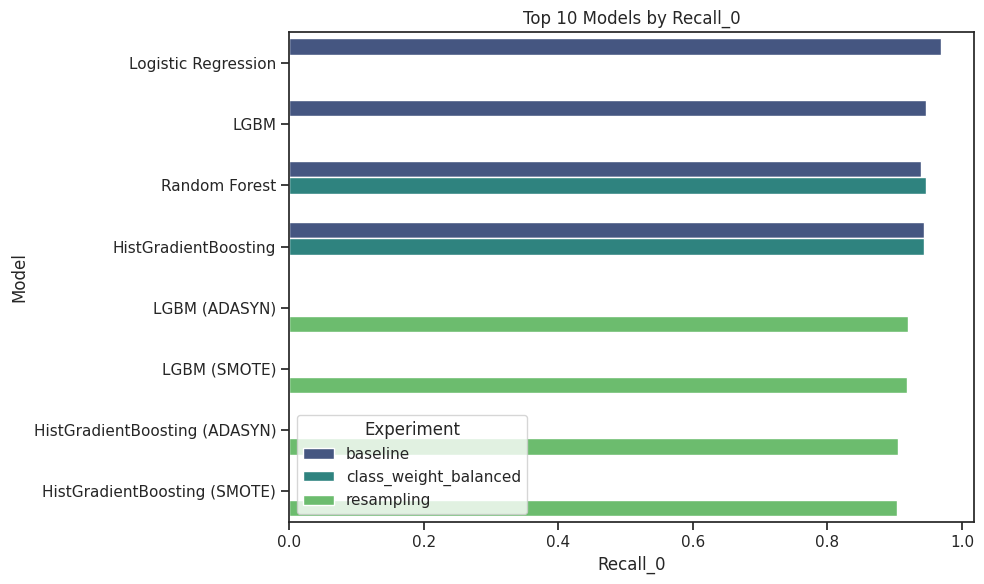

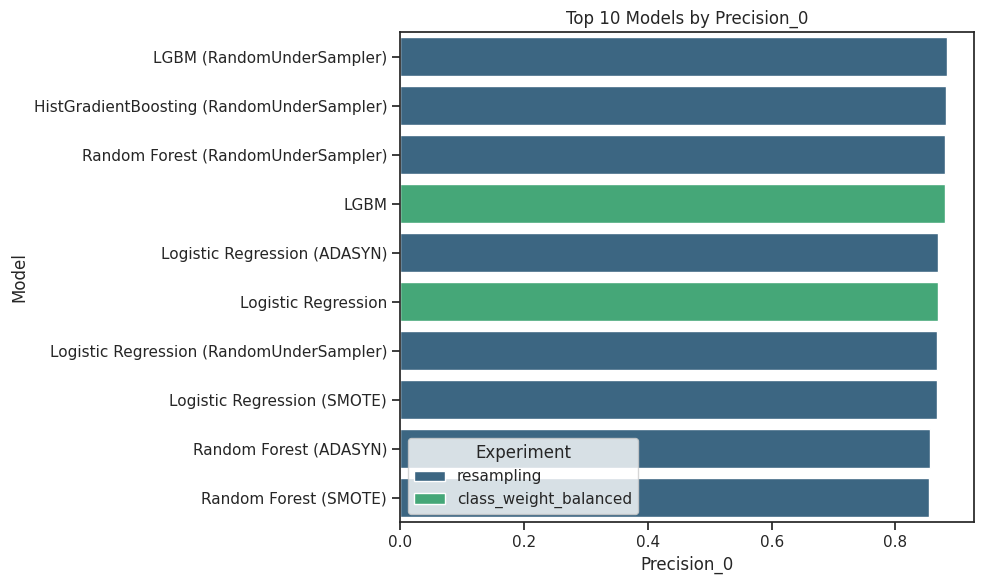

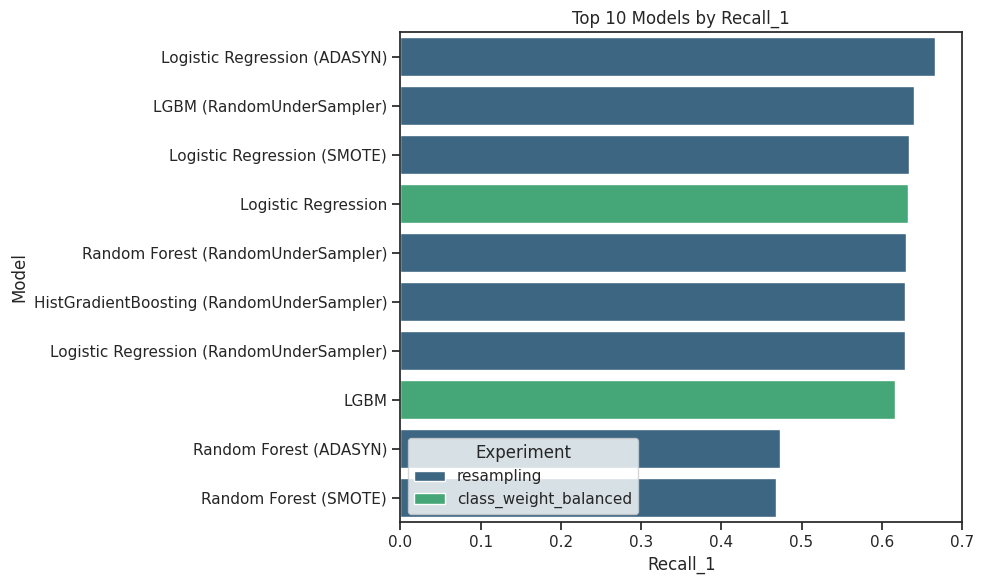

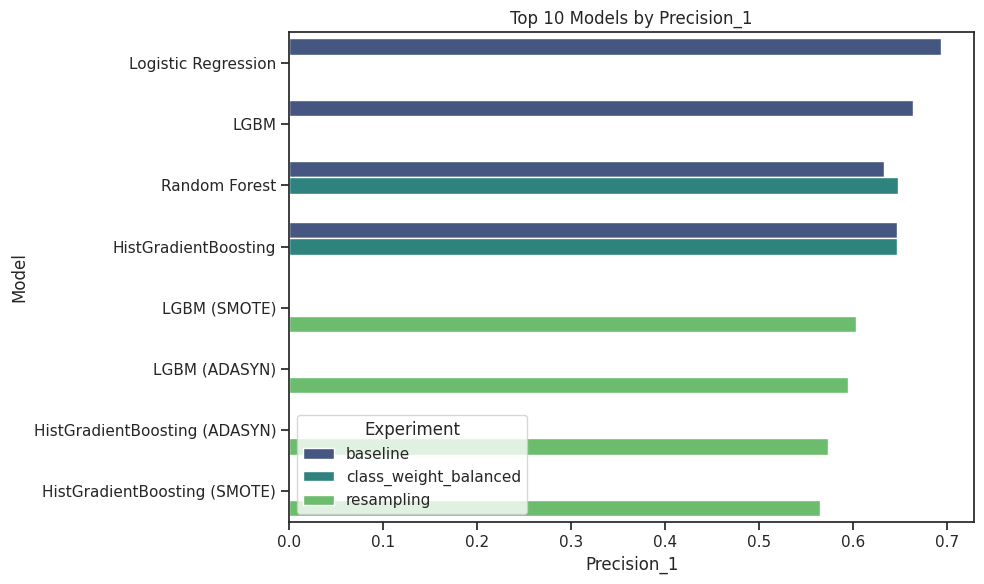

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top10_by_metric(metrics_df):
    metrics = ['Recall_0', 'Precision_0', 'Recall_1', 'Precision_1']

    for metric in metrics:
        sorted_df = metrics_df[['Experiment', 'Model', metric]].sort_values(by=metric, ascending=False).head(10).reset_index(drop=True)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=metric, y='Model', hue='Experiment', data=sorted_df, palette='viridis')
        plt.title(f"Top 10 Models by {metric}")
        plt.xlabel(metric)
        plt.ylabel('Model')
        plt.legend(title='Experiment', loc='lower left')
        plt.tight_layout()
        plt.show()

# Example usage
plot_top10_by_metric(combined_metrics_df)


#### Write Data Utils Script

In [59]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None


#--------   Evaluate and Capture Metrics   --------#

def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }

    logger.info(f"Completed evaluation for model: {model_name} ({experiment_name})")
    return metrics

def compile_metrics(metrics_list, experiment_name='experiment_name'):
    metrics_df = pd.DataFrame(metrics_list)
    csv_filename = f'{experiment_name}_metrics.csv'
    metrics_df.to_csv(csv_filename, index=False)
    logger.info(f"Metrics saved to {csv_filename}")
    return metrics_df


def plot_report(metrics_df, palette='viridis'):
    # Generate a summary report using matplotlib or seaborn
    metrics_to_plot = ['Precision_0', 'Recall_0', 'F1_0', 'Precision_1', 'Recall_1', 'F1_1', 'F1_Macro']
    titles = ['Precision Class 0', 'Recall Class 0', 'F1 Score Class 0', 'Precision Class 1', 'Recall Class 1', 'F1 Score Class 1', 'F1 Macro Score']

    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, len(metrics_to_plot) * 6))
    fig.suptitle('Model Performance Metrics', fontsize=20)

    for metric, title, ax in zip(metrics_to_plot, titles, axes):
        sns.barplot(x='Model', y=metric, hue=metric, data=metrics_df, palette='viridis', ax=ax, legend=False)
        ax.set_title(title)
        ax.set_ylabel(metric)
        ax.set_xlabel('Model')
        # ax.legend(title='Model Type')

        # Add average line for each metric
        mean_value = metrics_df[metric].mean()
        ax.axhline(mean_value, color='red', linestyle='--')
        ax.text(0.02, mean_value, f'Avg: {mean_value:.2f}', color='red', ha='left', va='center', transform=ax.get_yaxis_transform())

        # Correctly set tick labels
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig('model_performance_metrics_report.png')
    plt.show()
    logger.info("Generated performance report")

import matplotlib.pyplot as plt
import seaborn as sns

def plot_top10_by_metric(metrics_df):
    metrics = ['Recall_0', 'Precision_0', 'Recall_1', 'Precision_1']

    for metric in metrics:
        sorted_df = metrics_df[['Experiment', 'Model', metric]].sort_values(by=metric, ascending=False).head(10).reset_index(drop=True)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=metric, y='Model', hue='Experiment', data=sorted_df, palette='viridis')
        plt.title(f"Top 10 Models by {metric}")
        plt.xlabel(metric)
        plt.ylabel('Model')
        plt.legend(title='Experiment', loc='lower left')
        plt.tight_layout()
        plt.show()

# Example usage
plot_top10_by_metric(combined_metrics_df)

'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py


NameError: name 'combined_metrics_df' is not defined